In [61]:
import numpy as np
import tqdm
import pandas as pd
import matplotlib
matplotlib.use('webagg')
import matplotlib.pyplot as plt
plt.style.use('/home/hugo/Thèse/styles.mplstyle')

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

import sys
sys.path.append('../src')

from features import *

In [64]:
df = pd.read_pickle('../data/processed/dataset_cnsm.pkl')
# df = df[df.violin.isin([1,2,3,4,5,6])]
df = df[(df.violin.isin(['A', 'B', 'C']))]
# df = df.replace(['A', 'B', 'C'], [1, 2, 3])
# df = df.iloc[:10, :]

config = {
    'frame_size': 2048,
    'hop_ratio': 1,
    'n_coeff': 60,
    'sr': 8000,
    'feature': 'MFCC_welch',
    'sample_duration': 30,
}

config['hop_size'] = config['frame_size'] // config['hop_ratio']
data = []
for index, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    # offset = None
    # duration = None
    offset      = row['start']
    duration    = row['end'] - offset
    y, _        = librosa.load(str(row['file']), sr=config['sr'], offset=offset, duration=duration)

    # for audio in np.lib.stride_tricks.sliding_window_view(y, window_shape=config['sample_duration']*config['sr'])[::config['sample_duration']*config['sr']]:
    for audio in np.array_split(y, np.arange(config['sr'] * config['sample_duration'], len(y), config['sr'] * config['sample_duration'])):
    # for audio in np.array_split(y, config['sr'] * config['sample_duration']):
    # for audio in [y]:
        if len(audio) < config['sr'] * 10 :
            continue
        features = audio
        for step in pipes[config['feature']]:
            features = step(features, **config)

        dic = row.to_dict()
        dic.update(features=features)
        data.append(dic)

features_df = pd.DataFrame(data)

X = np.vstack(features_df.features)
y = features_df.violin.to_numpy()
sc = StandardScaler()

# scaler = StandardScaler()
scaler = MaxAbsScaler()
scaler.fit(X) 
X_scaled = scaler.transform(X)

100%|██████████| 1183/1183 [00:35<00:00, 33.15it/s]


In [39]:
print(X_scaled.shape)

(679, 140)


Explained variance ratio : [0.16085853 0.10313617]


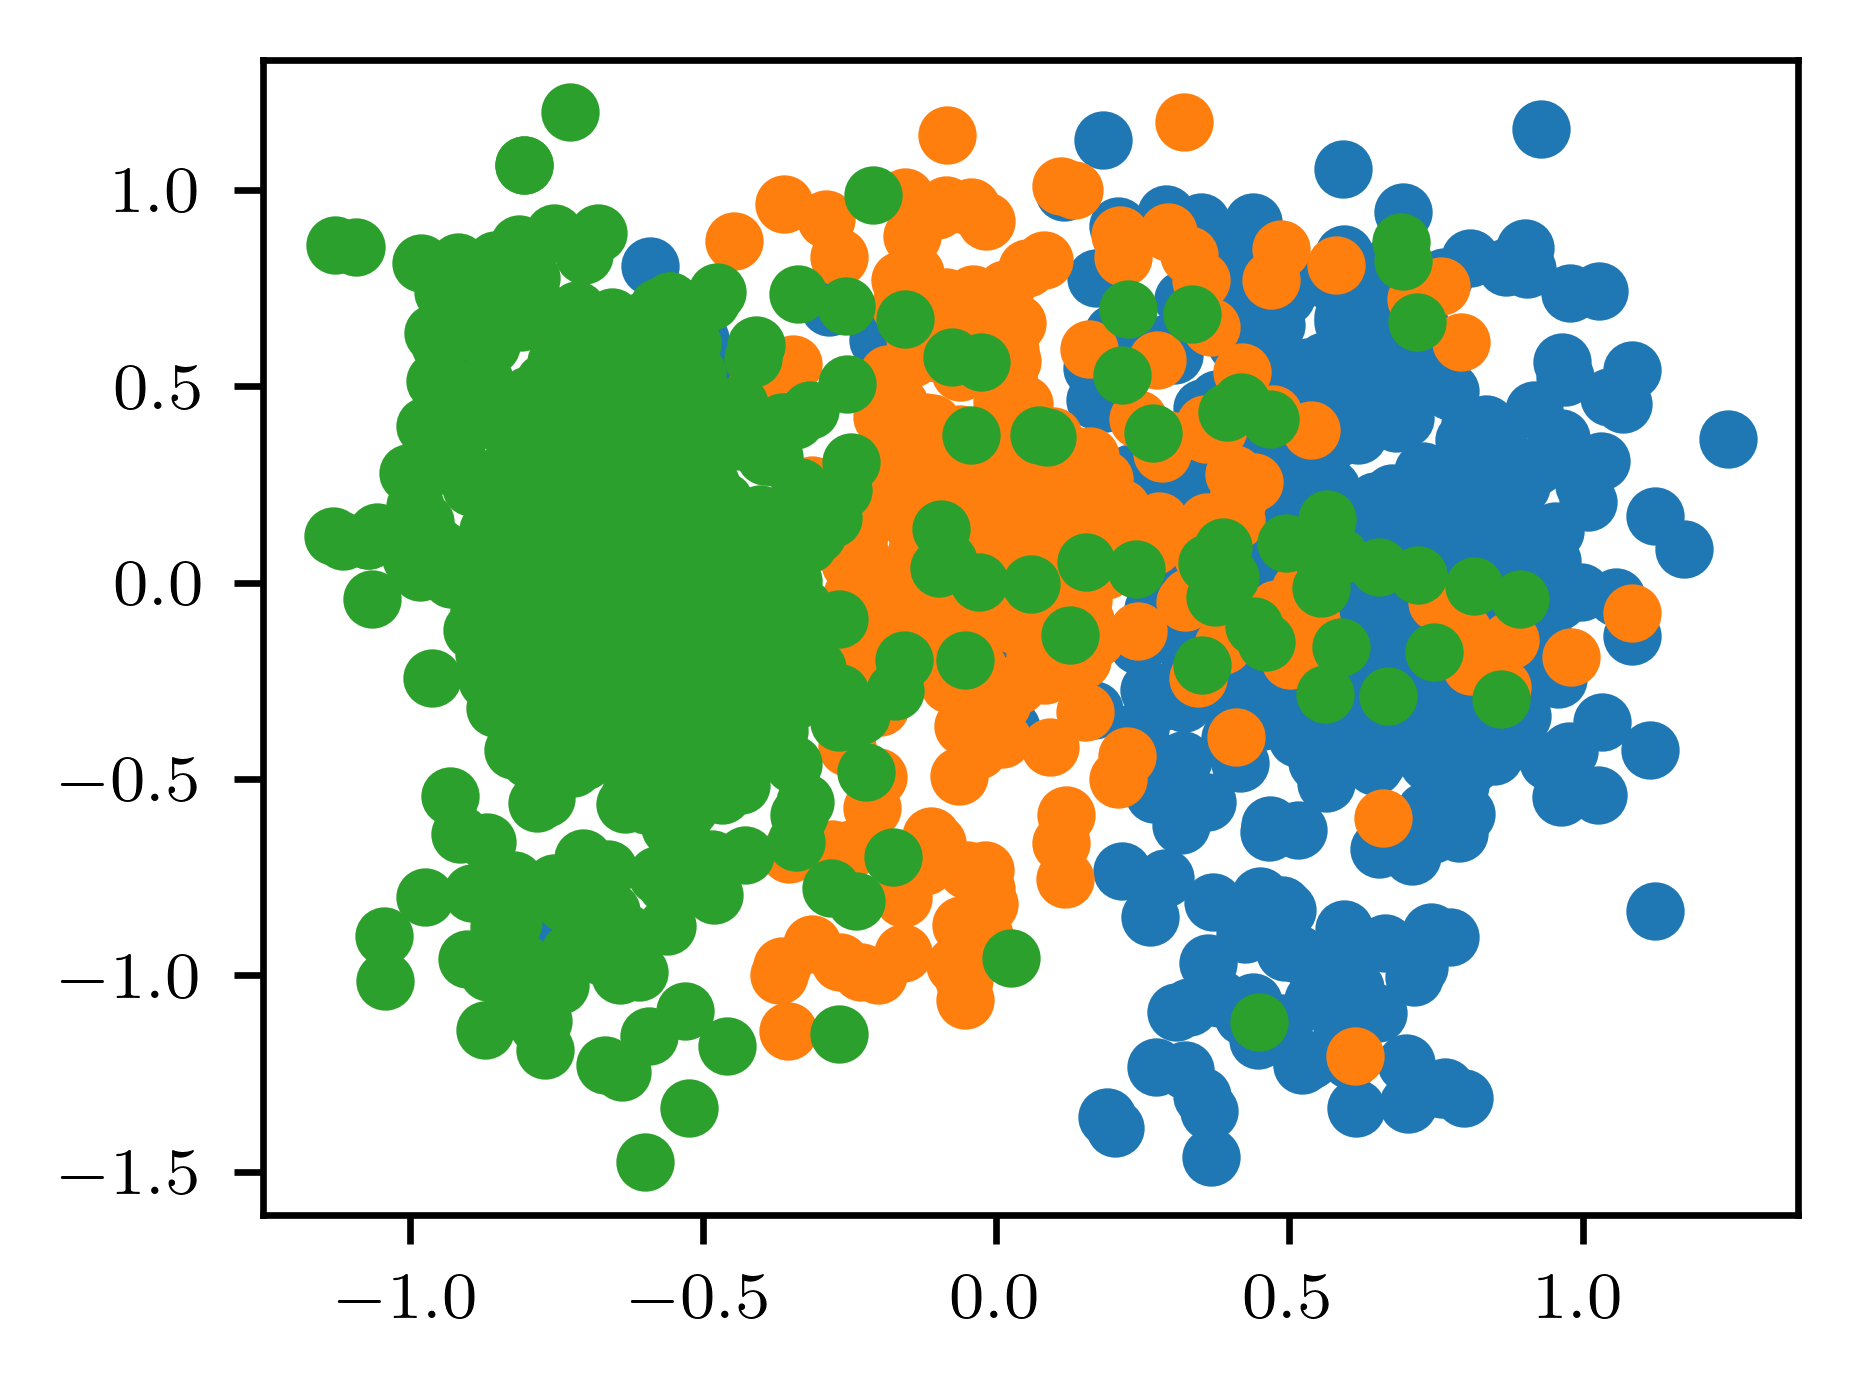

In [65]:
pca = PCA(n_components=2)
X_pca = pca.fit(X_scaled).transform(X_scaled)
print(f'Explained variance ratio : {pca.explained_variance_ratio_}')

color = ['red', 'green', 'blue']
plt.figure()
for l in np.unique(y):
    plt.scatter(
        X_pca[y == l, 0], X_pca[y == l, 1], label=f'Violin {l}'
    )


Explained variance ratio : [0.16085853 0.10313617 0.07670595]


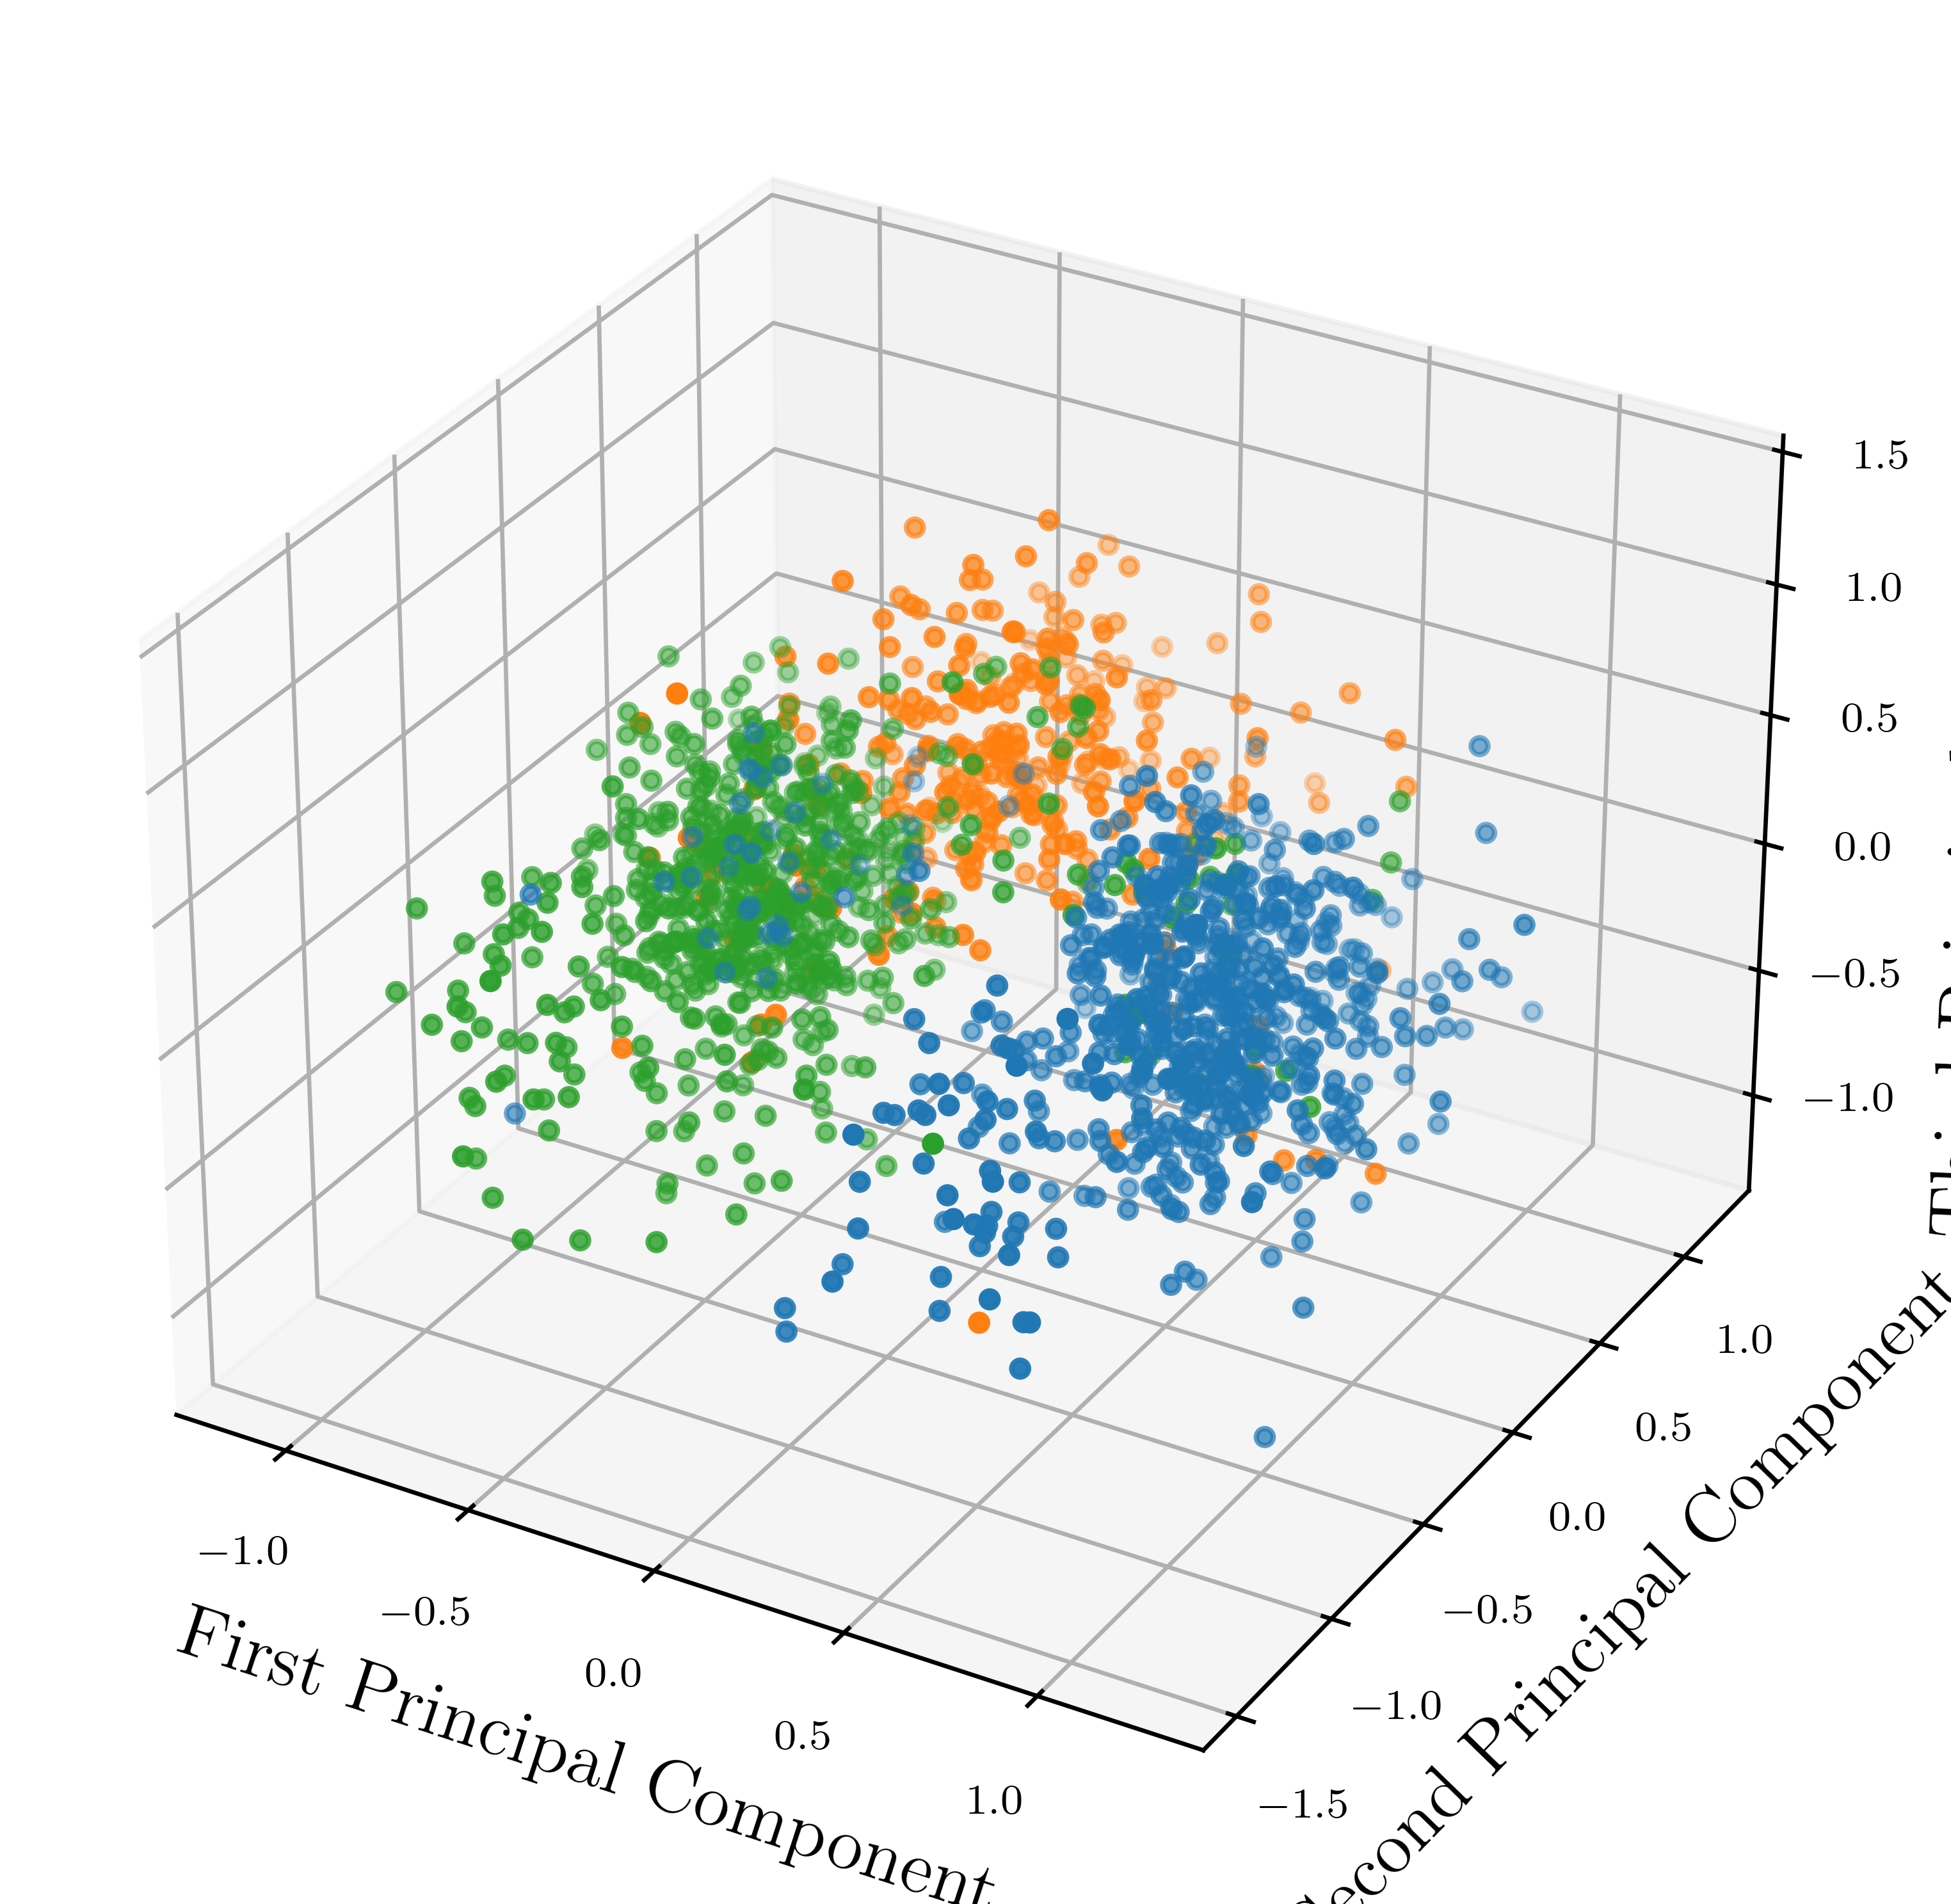

<Figure size 1980x1500 with 0 Axes>

In [66]:
pca = PCA(n_components=3)
X_pca = pca.fit(X_scaled).transform(X_scaled) 
print(f'Explained variance ratio : {pca.explained_variance_ratio_}')

Xax = X_pca[:,0]
Yax = X_pca[:,1]
Zax = X_pca[:,2]

# cdict = ['red', 'green', 'blue']

%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
fig.patch.set_facecolor('white')
for l in np.unique(y):
    ix = np.where(y==l)
    ax.scatter(Xax[ix], Yax[ix], Zax[ix], s=10, label=f'Violin {l}')
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

# ax.legend()
plt.tight_layout()
plt.show()
plt.savefig(f'../reports/figures/pca.svg')

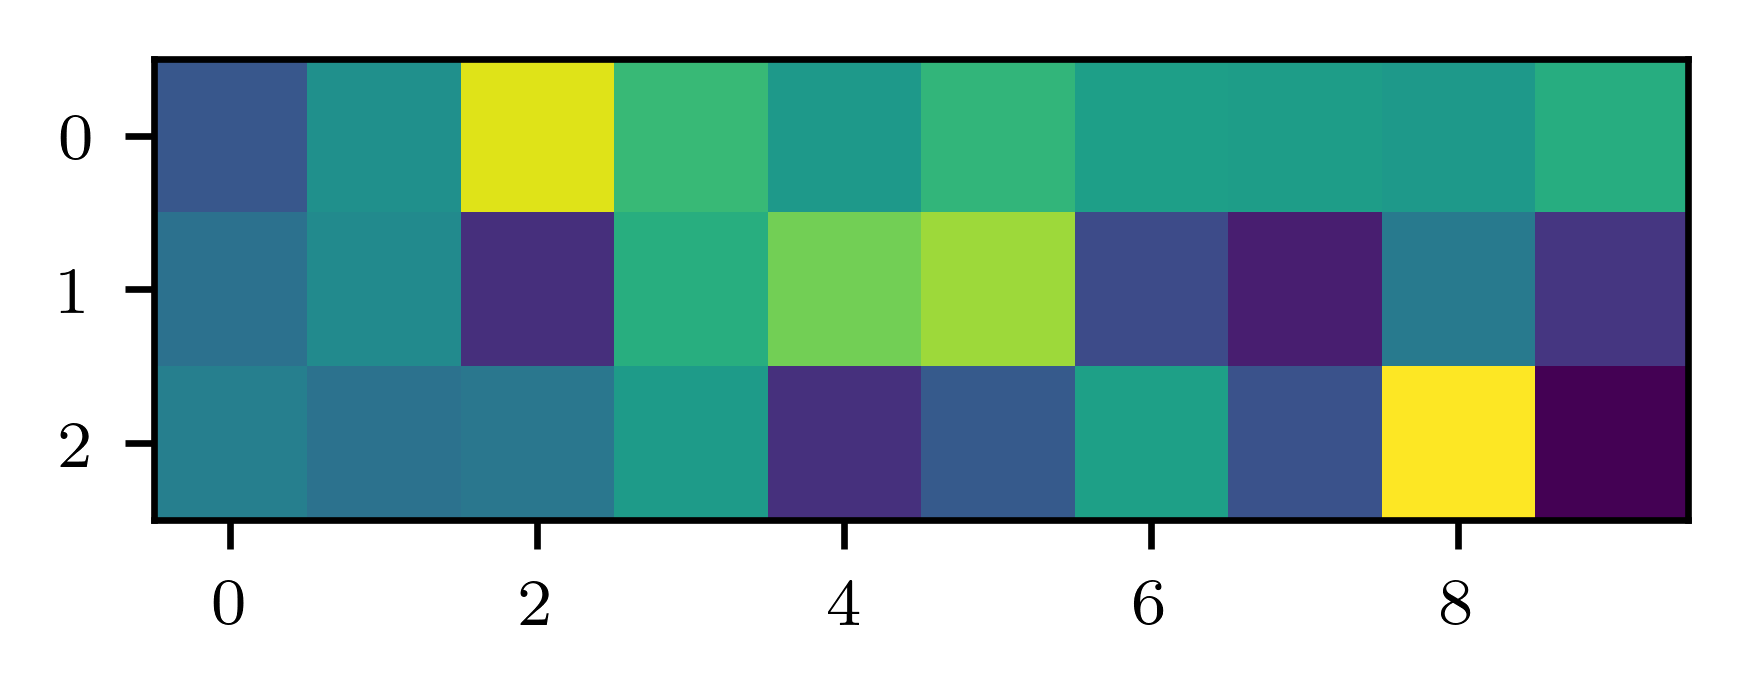

In [54]:
plt.imshow(pca.components_)